# 미리 증강시켜둔 이미지 데이터 불러오기

In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# 데이터 경로
image_path = r'C:\Users\amk25\D\clipped_(4)'
# 레이블 정의
labels = []

# 이미지 데이터 로드 및 전처리
def load_images_and_labels(image_path, target_size=(200, 200)):
    image_data = []
    labels = []
    
    image_files = os.listdir(image_path)
    
    for image_file in image_files:
        if 'fail' in image_file:
            label = 1
        else:
            label = 0
        labels.append(label)
            
        image = cv2.imread(os.path.join(image_path, image_file), cv2.IMREAD_GRAYSCALE)
        if image is not None:
            resized_image = cv2.resize(image, target_size)
            image_data.append(resized_image)

    return np.array(image_data), np.array(labels)

images, labels = load_images_and_labels(image_path)

In [2]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용하여 문자열 레이블을 정수로 매핑
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# 이미지 정규화
images_normalized = images / 255.0

# 정수 레이블을 원-핫 인코딩
labels_one_hot = to_categorical(integer_labels)

print("Original labels:", labels)
print("Integer labels:", integer_labels)
print("One-hot encoded labels:\n", labels_one_hot)

Original labels: [1 1 1 ... 0 0 0]
Integer labels: [1 1 1 ... 0 0 0]
One-hot encoded labels:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [3]:
print("images_normalized shape:", images_normalized.shape)
print("labels_one_hot shape:", labels_one_hot.shape)

images_normalized shape: (2095, 200, 200)
labels_one_hot shape: (2095, 2)


# 이미지 데이터 훈련
### <실수>
##### !!테스트 데이터는 증강된 데이터를 사용하면 안 돼요.....!!
- 테스트 데이터는 실제 환경에서 얼마나 잘 수행하는지 평가하기 위한 데이터임
- 따라서 테스트 데이터는 이전에 본 적이 없는 데이터를 사용해야 함
- 학습 데이터와 테스트 데이터 간에 불일치가 발생할 수 있음
- 이는 모델이 학습한 패턴이 테스트 데이터에 적용되지 않을 수 있음을 의미

In [4]:
# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, labels_one_hot, test_size=0.2, random_state=42)

# 이미지 데이터 형태 조정
X_train = X_train.reshape((-1, 200, 200, 1))
X_test = X_test.reshape((-1, 200, 200, 1))


# 모델 구성
# CNN 모델 구축
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    # 추가적인 층 추가 가능
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')  # 클래스 수에 맞게 조정
])

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# 성능 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# 모델 저장
model.save('sticker_classifier_model.h5')

Epoch 1/10
53/53 [==============================] - 12s 215ms/step - loss: 1.4757 - accuracy: 0.5209 - val_loss: 0.6930 - val_accuracy: 0.5131
Epoch 2/10
53/53 [==============================] - 12s 221ms/step - loss: 0.6928 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 3/10
53/53 [==============================] - 12s 222ms/step - loss: 0.6928 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 4/10
53/53 [==============================] - 12s 221ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131
Epoch 5/10
53/53 [==============================] - 12s 221ms/step - loss: 0.6925 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131
Epoch 6/10
53/53 [==============================] - 12s 221ms/step - loss: 0.6925 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131
Epoch 7/10
53/53 [==============================] - 12s 232ms/step - loss: 0.6924 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131

C:\Users\amk25\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 64)                20072512  
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20072962 (76.57 MB)
Trainable params: 20072962 (76.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

Epoch 1/10
53/53 [==============================] - 12s 220ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131
Epoch 2/10
53/53 [==============================] - 12s 224ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 3/10
53/53 [==============================] - 12s 222ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5131
Epoch 4/10
53/53 [==============================] - 12s 221ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 5/10
53/53 [==============================] - 12s 223ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 6/10
53/53 [==============================] - 13s 255ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 7/10
53/53 [==============================] - 13s 248ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131

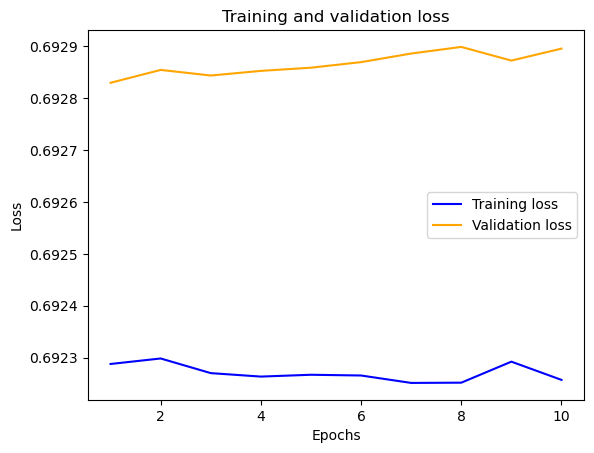

In [6]:
import matplotlib.pyplot as plt

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련 및 history 객체 얻기
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 이전에 훈련한 모델의 history 객체에서 loss 및 val_loss를 가져옵니다.
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss') 
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
53/53 [==============================] - 13s 233ms/step - loss: 0.6922 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 2/10
53/53 [==============================] - 13s 247ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 3/10
53/53 [==============================] - 13s 245ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 4/10
53/53 [==============================] - 13s 247ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6930 - val_accuracy: 0.5131
Epoch 5/10
53/53 [==============================] - 13s 254ms/step - loss: 0.6922 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 6/10
53/53 [==============================] - 13s 244ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6930 - val_accuracy: 0.5131
Epoch 7/10
53/53 [==============================] - 14s 262ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6929 - val_accuracy: 0.5131

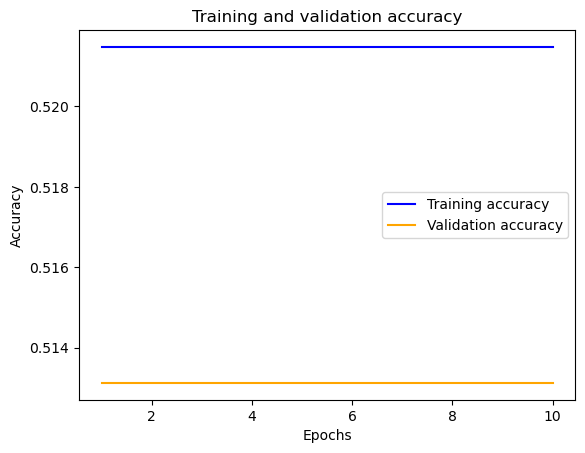

In [7]:
import matplotlib.pyplot as plt

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련 및 history 객체 얻기
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 이전에 훈련한 모델의 history 객체에서 accuracy 및 val_accuracy를 가져옵니다.
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(accuracy) + 1)

# Training and validation accuracy plot
plt.plot(epochs, accuracy, 'b', label='Training accuracy')  # ‘bo’는 파란색 점을 의미합니다.
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy') # ‘b’는 파란색 실선을 의미합니다.
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

39/39 [==============================] - 4s 110ms/step


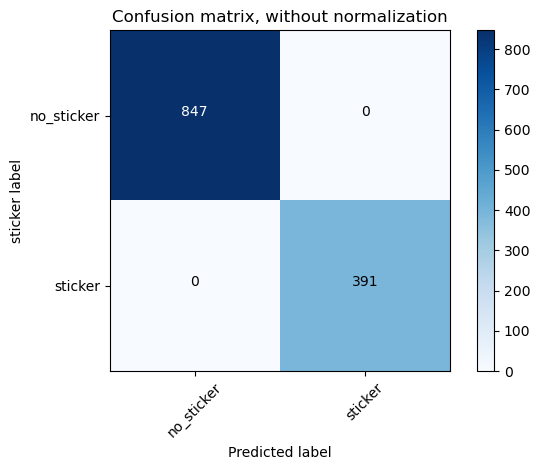

              precision    recall  f1-score   support

  no_sticker       1.00      1.00      1.00       847
     sticker       1.00      1.00      1.00       391

    accuracy                           1.00      1238
   macro avg       1.00      1.00      1.00      1238
weighted avg       1.00      1.00      1.00      1238



In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('sticker label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plot_confusion_matrix(conf_matrix, classes=['no_sticker', 'sticker'], title='Confusion matrix, without normalization')
plt.show()

# Classification Report
class_names = ['no_sticker', 'sticker']
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 [==============================] - 0s 86ms/step


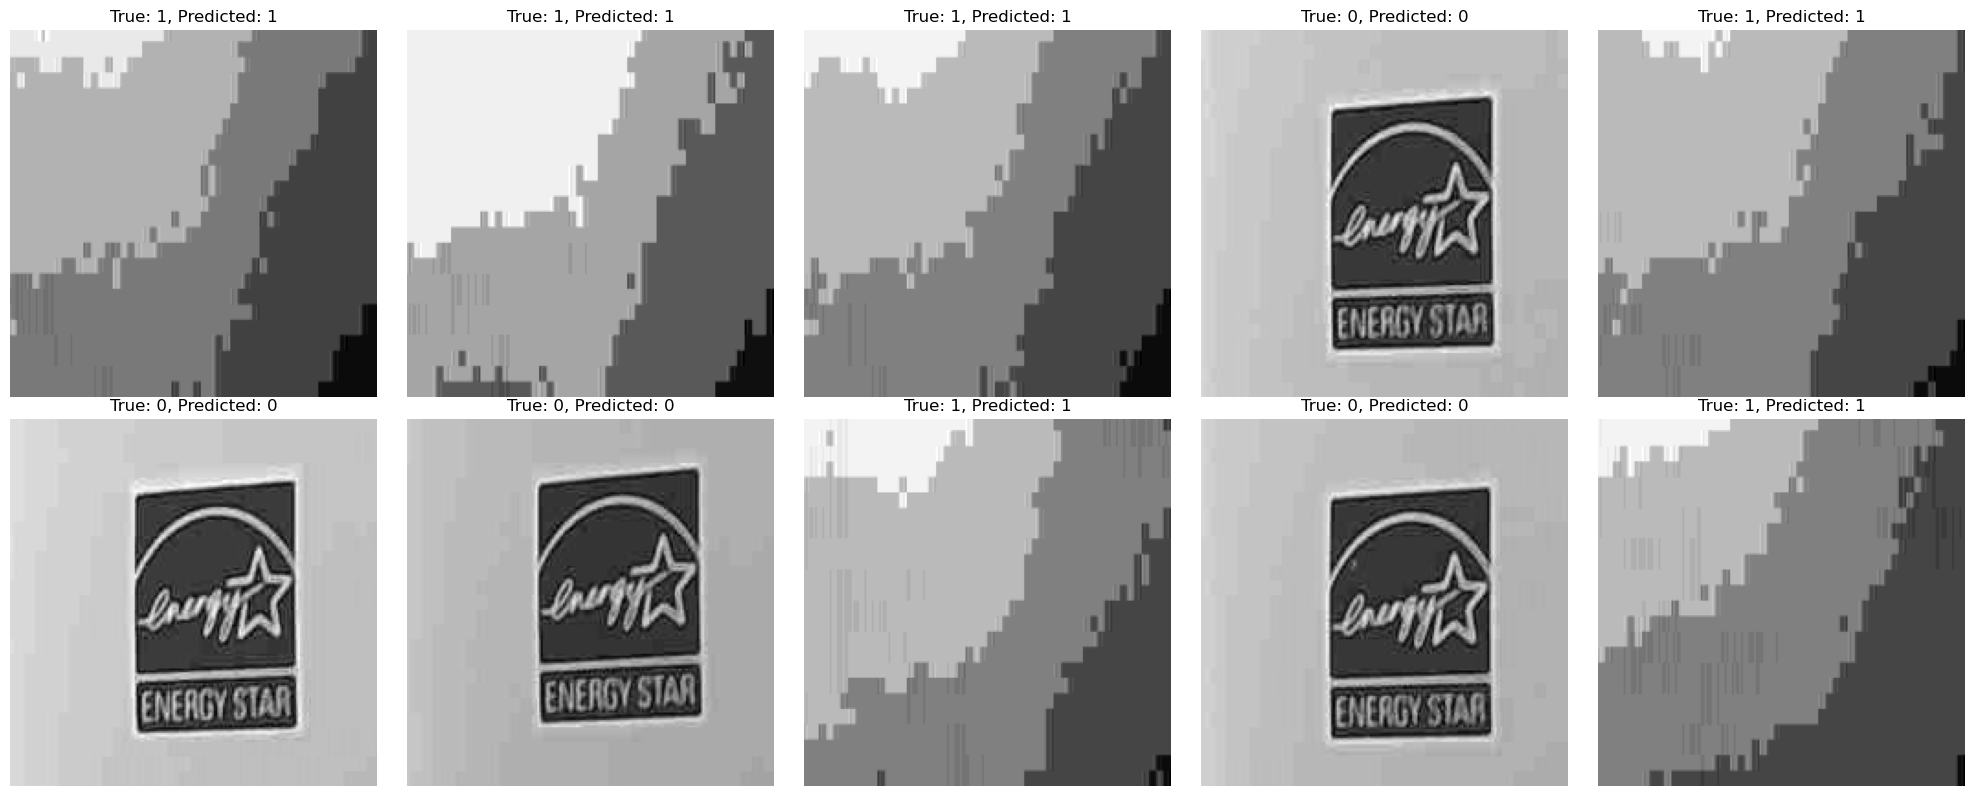

In [9]:
import matplotlib.pyplot as plt

# 테스트 이미지 중 일부를 선택
num_images = 10  # 시각화할 이미지 수
sample_indices = np.random.choice(np.arange(len(X_test)), num_images, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# 모델의 예측 수행
predictions = model.predict(sample_images)

# 시각화
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2행 5열의 그리드 생성
for i, ax in enumerate(axes.flatten()):
    # 이미지 데이터 형태 변경: 채널 정보를 제거하고 2차원으로 변환
    image = sample_images[i].reshape(200, 200)
    image = image * 255
    # 실제 레이블과 예측된 레이블 추출
    true_label = np.argmax(sample_labels[i])
    predicted_label = np.argmax(predictions[i])
    # 이미지와 레이블을 축에 표시
    ax.imshow(image, cmap='gray')
    ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
    ax.axis('off')  # 축 정보 제거
plt.tight_layout()
plt.show()